# Модель для прогнозирования оттока клиентов для сервиса доставки кофе

# План работы

## Этап 1. Подготовка среды и библиотек
1. Установите и настройте библиотеки. Для воспроизводимости результатов зафиксируйте версии пакетов в файле `requirements.txt`.

2. Зафиксируйте `random_state`.

3. Загрузите данные из CSV-файла. Путь к файлу: `'/datasets/coffee_churn_dataset.csv'`. Используйте сепаратор `","`, а для чтения чисел с плавающей точкой — параметр `decimal="."`.

In [1]:
'''---Импорт библиотек и модулей---'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import phik

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score
)
import joblib

In [2]:
'''---Фиксируем SEED---'''
SEED =42
random_state = SEED
np.random.seed(SEED)
random.seed(SEED)

In [3]:
'''---Извлекаем данные---'''
df_orig = pd.read_csv('https://code.s3.yandex.net/datasets/coffee_churn_dataset.csv', sep=',', decimal='.')
df_orig.head(5)

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
0,user_00318,0.0,12.942519,NaN,316.833872,260.645090,3089.991009,NaN,0.337031,blend,...,1.0,5.176792,3.302238,NaN,summer,6.0,android,0.0,geo_75,1
1,user_07234,2.0,1.569146,0.214494,780.135158,540.597850,998.380941,107.369409,0.547659,arabica,...,1.0,4.392991,NaN,0.0,autumn,16.0,ios,0.0,geo_95,0
2,user_04816,11.0,2.996666,0.771864,682.636256,471.494559,1328.140204,392.600011,0.120258,arabica,...,1.0,4.977712,4.379219,0.0,spring,11.0,web,1.0,geo_25,0
3,user_04419,0.0,4.299255,1.210480,2115.487425,708.529812,2999.628366,1084.352054,NaN,robusta,...,1.0,3.712526,3.043618,0.0,summer,3.0,android,0.0,geo_2,0
4,user_09698,3.0,7.249864,1.761027,3519.602170,1199.372894,8377.729478,2551.775211,0.074990,robusta,...,0.0,4.528271,5.642993,1.0,winter,14.0,ios,0.0,geo_19,1


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

### Вывод по Этапу 1
1. Подгружены и импортированы необходимые библиотеки для проекта;
2. Зафиксирован `random_state` для воспроизводимости;
3. Выгруженны данные и получена первичная информация о них:
    - Загружены данные: 10 450 клиентов, 27 признаков;
    - Некотрые признаки(14 из 27) имеют пропуски в данных;
    - Типы данных корректны, но есть несоответствия в названии признака 25(в датасете `geo_location`, а в описании задания `geo_id`)
    - Целевая переменная `churn` в данных не содержит пропусков

## Этап 2. Первичный анализ данных

1. Опишите данные. Кратко сообщите, что известно о пользователях и их поведении.

2. Опишите целевую переменную. Обратите внимание на возможные особенности её распределения. Проверьте, наблюдается ли дисбаланс классов в целевой переменной.

3. Опишите признаки.

   - Определите, все ли из них важны.

   - Объясните, какие из них можно удалить (если такие есть). Аргументируйте своё решение.

4. Обработайте пропущенные значения.
   
   - Объясните, как они влияют на данные.

   - Выберите стратегию заполнения пропусков.

5. Проанализируйте категориальные признаки.

   - Выясните, есть ли в данных признаки, которые можно кодировать. Объясните, почему именно их нужно кодировать.

   - Проанализируйте признаки на предмет того, можно ли использовать некоторые из них для генерации новых  признаков. Укажите возможные стратегии.

   - Определите, есть ли в данных признаки, которые можно удалить.

6. Проанализируйте выбросы.

   - Определите, как они влияют на данные.

   - Выберите способ, которым их можно обработать.

7. Посчитайте корреляции между признаками. Постройте необходимые визуализации. Определите, есть ли признаки, которые можно убрать, на основании их корреляции с другими.

8. Напишите выводы по результатам исследовательского анализа данных.

In [5]:
'''---Размер датасета---'''
df_orig.shape

(10450, 27)

#### Описание данных
1. Данные содержат 10 450 клиентов - строк и 27 признаков. Пользователи заказывают кофе пользуясь приложениями со смартфонов или сайтом на компьютере. Пользователи имеют различные вкусовые предпочтения по кофе и молоку, а также различную географию заказов.
2. Поведение пользователей отражено в признаках, которые можно разделить на несколько групп:
    - **платежная информация** - цены, чеки, платежи и заказы  
                        (Признаки `days_since_last_order`, `order_frequency_month`,
                                  `order_frequency_week`, `avg_order_value`,
                                  `median_order_value`, `total_spent_last_month`,
                                  `total_spent_last_week`, `discount_usage_rate`
                                  ). 
    Это важная группа признаков, которая имеет ценность для обучения модели и предсказанния оттока клиентов. Эти признаки содержат ценность клиента для кофейни, регулярность заказов и насколько давно клиент делал последний заказ. 
    - **вовлеченность и активность клиента** (Признаки `app_opens_per_week`,    `notifications_enabled`,
                                                    `days_since_last_promo`, `subscription_status`,
                                                    ). Эти признаки связаны с лояльностью клиента, важны для удержания и могут быть полезны для обучения модели.
    - **опыт пользования и оценка клиетов** (Признаки `review_rating_last_10`, `review_rating_last_1`, `app_crashes_last_month`). Данные признаки могут являться или индикаторами или причиннами оттока. Плохие отзывы и оценки, а также стабильность работы приложения напрямую влияют на лояльность.
    - **вкусовые предпочтения клиентов** (Признаки `last_coffee_type`, `preferred_roast`, `milk_preference`, `seasonal_menu_tried`, `last_drink_size`, `coffee_bean_origin`, `coffee_preference_change`). Признаки, которые, если и влияют на отток, но не очевидно. Например, признак о смене предпочтений `coffee_preference_change` может коррелировать с оттоком. Смена предпочтений - нестабильность привержености к одному типу напитка/заведения и т.д.
    - **фоновый признаки** (Признаки `seasons`, `geo_id`, `phone_type`). Вряд ли эти признаки могут быть связаны с отоком клиентов. Разве что время года может влиять на потребление кофе - например, в жаркую погоду кофе хочется меньше. По геопозициям ничего сказать нельзя, но если есть регионы, где кофе пьют меньше, то логично, что оттуда и не было бы клиентов изначально. Поэтому геопозиция вряд ли связана с оттоком. А тип устройства - может быть связан. Приложение может по разному работать на разных типах устройства.
    - **иднетификатор пользователя** `user_id` точно никак не поможет в обучении модели, его можно удалить. По остальным признакам, желательно дополнительно оценить корреляцию. Основные признаки, которые с большей вероятностью повлияют на модель - это первые две группы.


Смотрим информацию о целевой переменной `churn`, которая обозначает отток клиентов (1 - клиент ушел, 0 - не ушел). Исходя из описания задания и логики, классы целевой переменной распределенны неравномерно. Убедимся в этом. 

In [6]:
class_dist = df_orig['churn'].value_counts(normalize=True)
for num_clas in [0, 1]:
    print(f"Класс {num_clas}: {round(class_dist[num_clas]*100, 3)}, %")

Класс 0: 93.981, %
Класс 1: 6.019, %


Дисбаланс классов подтверждается. 
По информации из датасета отток составил около 6 % (данные, по описанию проекта, даны за 4 недели, значит за месяц ушло 6% клиентов).

In [7]:
'''---Работа с пропусками---'''
def show_missing_stats(df):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': df.isnull().sum(),
        'Доля пропусков': df.isnull().mean()
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    # Форматируем при выводе через Styler
    return (missing_stats.style.format({'Доля пропусков': '{:.3f}'}).background_gradient(cmap='coolwarm'))
show_missing_stats(df_orig)

,Кол-во пропусков,Доля пропусков
days_since_last_order,945,0.090
order_frequency_month,600,0.057
order_frequency_week,388,0.037
avg_order_value,583,0.056
median_order_value,831,0.080
total_spent_last_month,294,0.028
total_spent_last_week,944,0.090
discount_usage_rate,397,0.038
last_coffee_type,258,0.025
preferred_roast,116,0.011


Пропущенных значение около 5-9 %, это относительно немного, но с учетом несбалансированных классов по целевой переменной удаление этих строк может быть критическим. Поэтому пропуски необходимо обработать. Кроме того, пропуски в разных признаках могут иметь различную природу и быть связанны с оттоком клиентов. Например, пропуски в признаках `days_since_last_order`, `total_spent_last_week`, могут означать, что заказов не было, что связанно с оттоком клиентов. Это можно проверить. Это можно проверить перед тем как решить, что делать с этими пропусками. Для числовых признаков с пропусками, создадим дополнительно индикаторные признаки, где 1 - означает пропуск. Потом рассчитаем корреляцию с целевой переменной. Если корреляция низкая, значит пропуски не связаны с оттоком клиентов и их можно заменить медианным значение. 

In [8]:
'''---Расчет корреляции пропусков с целевой переменной---'''
# делим признаки на числовые и категориальные 
numeric_feature = ['days_since_last_order', 'order_frequency_month',
                   'order_frequency_week', 'avg_order_value',
                   'median_order_value', 'total_spent_last_month',
                   'total_spent_last_week', 'discount_usage_rate',
                   'seasonal_menu_tried', 'app_opens_per_week',
                   'notifications_enabled', 'review_rating_last_10',
                   'review_rating_last_1', 'app_crashes_last_month',
                   'days_since_last_promo', 'coffee_preference_change'
    
]
categorial_features = ['last_coffee_type', 'preferred_roast',
                       'milk_preference', 'coffee_bean_origin',
                       'last_drink_size', 'subscription_status',
                       'seasons', 'phone_type',
                       'geo_location']
target = 'churn' # целевая переменная

In [9]:
# Создаем индикаторы пропусков для всех числовых признаков
for col in numeric_feature:
    df_orig[f'{col}_missing'] = df_orig[col].isnull().astype(int)
    
# Проверяем корреляцию
correlations = {}
for col in numeric_feature:
    corr=df_orig[f'{col}_missing'].corr(df_orig['churn'])
    correlations[col] = corr
    if abs(corr) > 0.1:
        print(f"Значимая корреляция пропусков в {col} с churn: {corr:.2f}")
    else: print('Корреляция для признака:', col, abs(corr))

Корреляция для признака: days_since_last_order 0.0015700196321923466
Корреляция для признака: order_frequency_month 0.02055534058876194
Корреляция для признака: order_frequency_week 0.005009671129583606
Корреляция для признака: avg_order_value 0.015616618690799862
Корреляция для признака: median_order_value 0.011868685050261209
Корреляция для признака: total_spent_last_month 0.010471847909552506
Корреляция для признака: total_spent_last_week 0.012883658361744864
Корреляция для признака: discount_usage_rate 0.010741929846462987
Корреляция для признака: seasonal_menu_tried 0.019970576734537254
Корреляция для признака: app_opens_per_week 0.011397796548140132
Корреляция для признака: notifications_enabled 0.0012341169620569289
Корреляция для признака: review_rating_last_10 0.007619944909465078
Корреляция для признака: review_rating_last_1 0.009408243276793876
Корреляция для признака: app_crashes_last_month 0.008569263324783756
Корреляция для признака: days_since_last_promo 0.00788688167142

Корреляция пропусков с уходом клиентов не прослеживается.
Также проверим сколько пропусков содержат записи, где клиенты ушли.

In [10]:
df_orig_churn = df_orig[df_orig['churn']==1]
show_missing_stats(df_orig_churn)

,Кол-во пропусков,Доля пропусков
days_since_last_order,58,0.092
order_frequency_month,48,0.076
order_frequency_week,21,0.033
avg_order_value,44,0.070
median_order_value,58,0.092
total_spent_last_month,22,0.035
total_spent_last_week,66,0.105
discount_usage_rate,29,0.046
last_coffee_type,18,0.029
preferred_roast,4,0.006


В процентном соотношении аналогично полному датасету. Похоже, что пропуски в числовых данных не связаны с оттоком клиентов. Это означает, что их можно заменить на медианные значения, но сделать это необходимо после разделения данных, чтобы избежать утечки.

In [11]:
# удаляем добавленные индикаторные признаки
missing_col = [f'{col}_missing' for col in numeric_feature if f'{col}_missing' in df_orig.columns]

col_to_drop = missing_col + ['user_id'] # удалим еще user_id, так как он не имеет ценности для обучения модели
df_orig = df_orig.drop(columns=col_to_drop, errors='ignore')

# проверяем
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_order     9505 non-null   float64
 1   order_frequency_month     9850 non-null   float64
 2   order_frequency_week      10062 non-null  float64
 3   avg_order_value           9867 non-null   float64
 4   median_order_value        9619 non-null   float64
 5   total_spent_last_month    10156 non-null  float64
 6   total_spent_last_week     9506 non-null   float64
 7   discount_usage_rate       10053 non-null  float64
 8   last_coffee_type          10192 non-null  object 
 9   preferred_roast           10334 non-null  object 
 10  milk_preference           9782 non-null   object 
 11  seasonal_menu_tried       9461 non-null   float64
 12  coffee_bean_origin        9768 non-null   object 
 13  last_drink_size           9946 non-null   object 
 14  subscr

Что касается пропусков категориальных признаков, тут два варианта: либо заполнить модой, либо значением "unknown" - если пропуски связаны с оттоком клиентов и могут влиять на обучение модели. На данный момент определим стратегию заполнения пропусков - "unknown", как отдельной категории признака. Это сохранит информацию об пропуске. Также этот момент также будет кодироваться. При построении пайплайна, можно будет проверить обе стратегии. 

Кодирование категориальных призаков обязательно, так как логистическая регрессия работает только с числовыми данными, и не может работать напрямую с текстовыми категориями. 

In [12]:
# Проверим количество уникальных значений для категориальных признаков
print(df_orig[categorial_features].nunique())

last_coffee_type         3
preferred_roast          3
milk_preference          6
coffee_bean_origin       6
last_drink_size          3
subscription_status      4
seasons                  4
phone_type               3
geo_location           100
dtype: int64


Для всех категориальных признаков колочество уникальных значенией до 10, это значит их все можно кодировать с помощью OneHotEcoder. Исключением является `geo_location`, но этот признак кандидат на удаление, так как к данной задаче он вряд ли содержит полезную информацию и не связан с оттоком клиентов.

In [13]:
print(df_orig['geo_location'].value_counts(normalize=True).head(15))

geo_location
geo_2      0.157544
geo_3      0.152128
geo_1      0.148162
geo_99     0.011315
geo_95     0.010638
geo_92     0.010445
geo_93     0.009478
geo_96     0.009381
geo_100    0.009284
geo_97     0.008897
geo_94     0.008511
geo_98     0.007737
geo_91     0.007737
geo_73     0.007447
geo_5      0.006673
Name: proportion, dtype: float64


Мы видим, что основная масса клиентов(почти 45%) сосредоточенная в трех регионах(geo_1, geo_2, geo_3). Остальные клиенты размазанны по 97 регионам. Про региональную стратегию бизнеса в задании не было указано. Поэтому в виду остуствия явной гипотоезы о влиянии географии, предлагается удалить этот признак. *Конечно, есть альтернативный вариант: можно оставить 4 категории geo_1, geo_2, geo_3 и other Это также легко кодируется OneHotEncoder, но все таки, в целях упрощения модели, мы удалим этот признак*. 

In [14]:
df_orig = df_orig.drop(columns='geo_location', errors='ignore')
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_order     9505 non-null   float64
 1   order_frequency_month     9850 non-null   float64
 2   order_frequency_week      10062 non-null  float64
 3   avg_order_value           9867 non-null   float64
 4   median_order_value        9619 non-null   float64
 5   total_spent_last_month    10156 non-null  float64
 6   total_spent_last_week     9506 non-null   float64
 7   discount_usage_rate       10053 non-null  float64
 8   last_coffee_type          10192 non-null  object 
 9   preferred_roast           10334 non-null  object 
 10  milk_preference           9782 non-null   object 
 11  seasonal_menu_tried       9461 non-null   float64
 12  coffee_bean_origin        9768 non-null   object 
 13  last_drink_size           9946 non-null   object 
 14  subscr

Относительно генерации новых признаков из категориальных данных, можно сделать,например, следующий новые бинарный признаки: `is_premium_plan` - есть премиальный тариф\нет примиального тарифа. Но этот признак лучше добавить на этапе создания базовой модели.
Если говорить про числовые признаки, то логично сделать: `sqrt_total_spent_last_month`-(корень из затрат за месяц), так как это большие числа, корень несколько сгладит, в том числе и выбросы и `days_since_last_order`-квадрат дней последнего заказа. Чем больше дней проходит с моента последнего заказа, тем выше вероятность, что клиент ушел. Квадрат будет усиливать сигнал.

Проверим выбросы на числовых признаках. Для этого сначала выведем статистическое описание, а потом построим боксплоты.

In [15]:
'''---Анализ выбросов---'''
df_orig[numeric_feature].describe()

,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,seasonal_menu_tried,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,days_since_last_promo,coffee_preference_change
count,9505.000000,9850.000000,10062.000000,9867.000000,9619.000000,10156.000000,9506.000000,10053.000000,9461.000000,9554.000000,9913.000000,9757.000000,9593.000000,9729.000000,9719.000000,9840.000000
mean,4.394214,4.025666,0.930686,1063.741207,452.651500,1946.132979,413.004760,0.284446,0.701194,11.330895,0.753052,4.206709,4.022460,1.013362,14.554584,0.192480
std,4.858757,2.826144,0.657261,707.713396,258.657571,2370.619590,445.634902,0.158735,0.457759,14.528887,0.431258,0.782212,1.207883,1.010342,15.308869,0.394268
min,0.000000,0.011046,-0.169131,-32.075932,-10.353340,-43.716463,-2290.559468,0.002162,0.000000,0.000000,0.000000,1.415526,-0.897000,0.000000,0.000000,0.000000
25%,1.000000,1.937767,0.445185,552.898663,262.908598,629.680382,136.565833,0.159884,0.000000,6.313628,1.000000,3.675543,3.214157,0.000000,4.000000,0.000000
50%,3.000000,3.381094,0.784839,898.643524,406.456818,1300.409757,288.277327,0.264583,1.000000,9.228383,1.000000,4.203555,3.990032,1.000000,10.000000,0.000000
75%,6.000000,5.439363,1.262350,1406.332153,590.418070,2481.650495,549.699420,0.387056,1.000000,12.726649,1.000000,4.717292,4.845225,2.000000,20.000000,0.000000
max,40.000000,27.389318,6.302624,5901.965278,2189.101644,79298.849570,8615.988952,0.887301,1.000000,224.587876,1.000000,7.384425,8.558443,7.000000,140.000000,1.000000


Из всех числовых признаков наиболее значимые, с точки зрения выбросов:
 - `days_since_last_order` - длинный правый хвост (max=40);
 - `order_frequency_month` и `order_frequency_week` -также имеет длинный правый хвост (max=27 max=6.3 соответственно)
 - признаки `avg_order_value`, `median_order_value`, `total_spent_last_month`, `total_spent_last_week` имеют длинные правые хвосты а также отрицательные значения
 - `app_opens_per_week`, `days_since_last_promo` - также наблюдаются длинные хвосты.
 - `app_crashes_last_month` - имеет максимум 7, но это реалистичное значение, возможно не выброс.
 - `review_rating_last_10` и `review_rating_last_1` - сильных отклонений не выявленно, медиана примерно совпадает со средним, но есть отрицательный минимум - что выходит за ожидаемую шкалу оценок.
 - `seasonal_menu_tried`, `notifications_enabled`, `coffee_preference_change` - бинарные признаки, по ним боксплот сроить не будем.
 - `discount_usage_rate` - ограничен от 0 до 1, выглядит реальным, распределение нормальное.

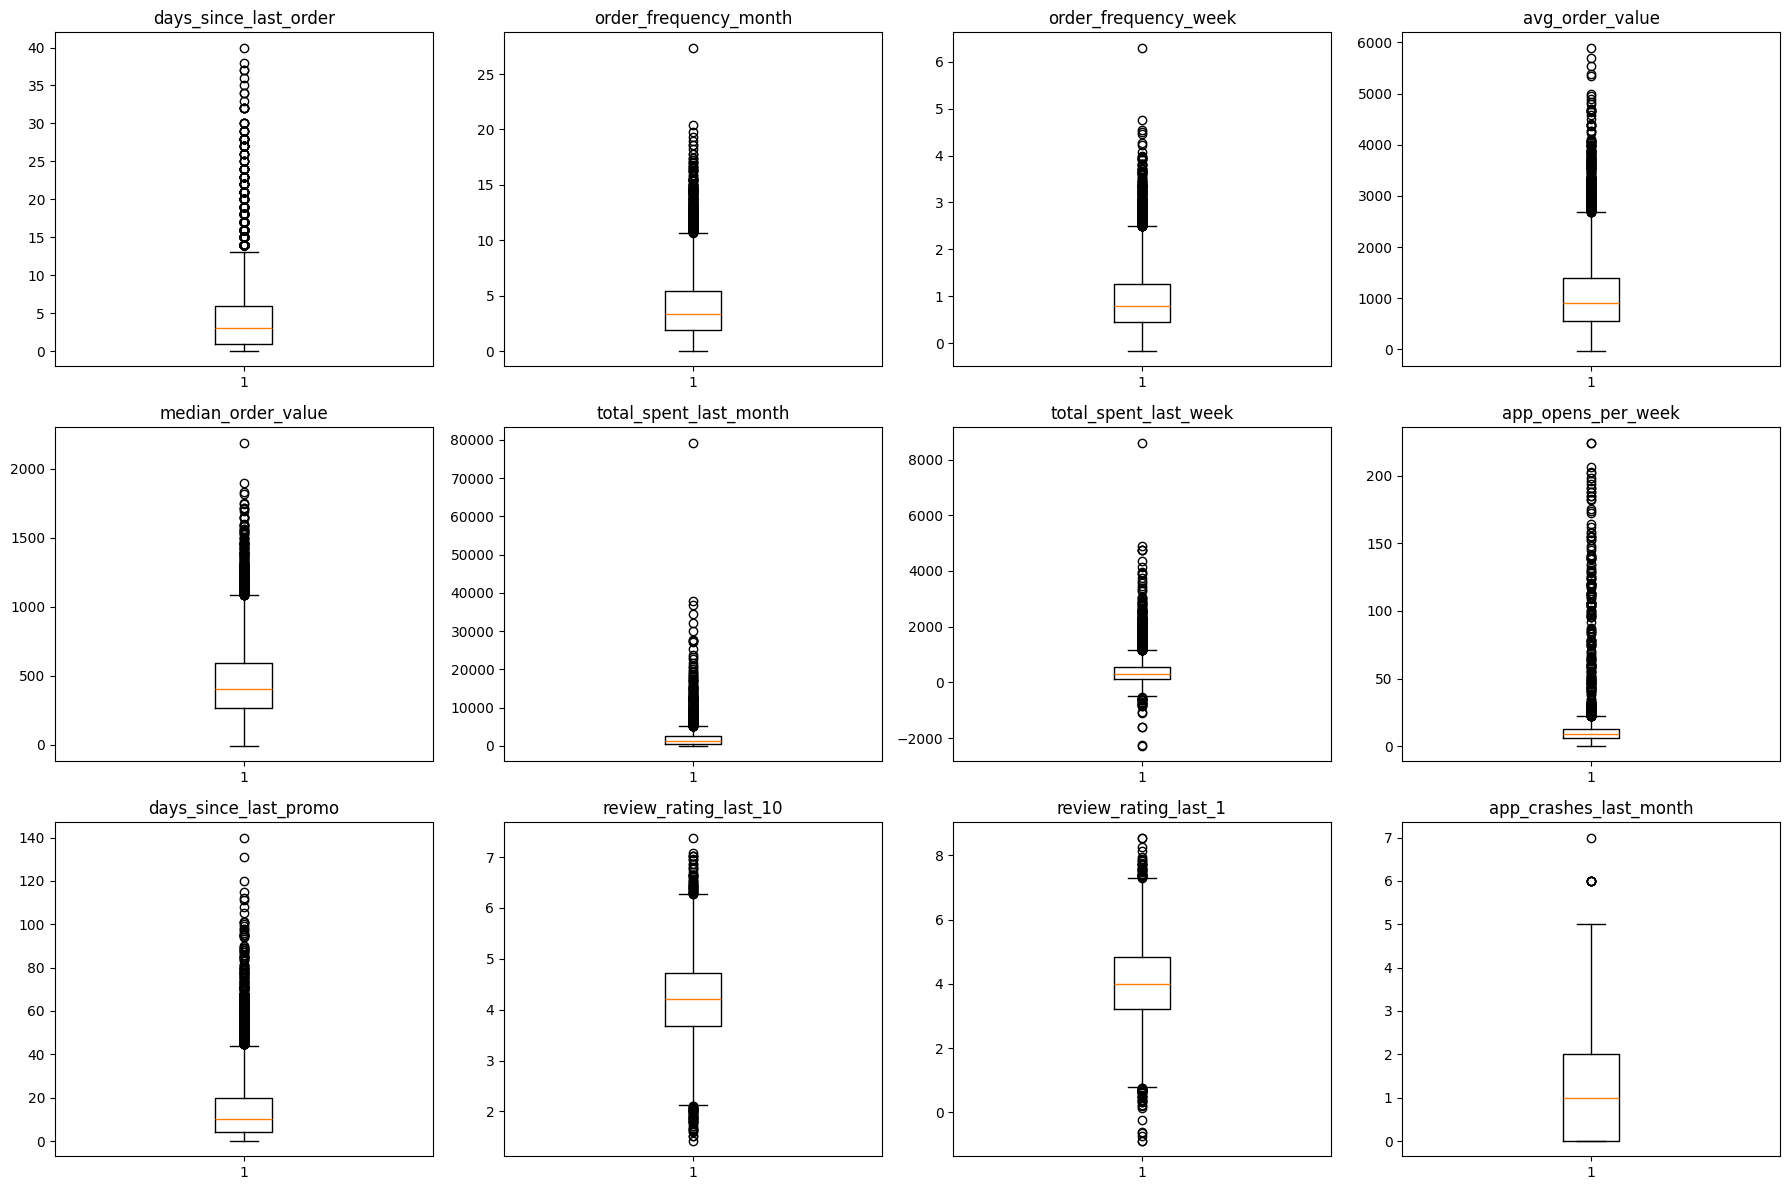

In [16]:
'''---Строим боксплоты для оценки выбросов---'''
boxplot_features = [
    'days_since_last_order',
    'order_frequency_month',
    'order_frequency_week',
    'avg_order_value',
    'median_order_value',
    'total_spent_last_month',
    'total_spent_last_week',
    'app_opens_per_week',
    'days_since_last_promo',
    'review_rating_last_10',
    'review_rating_last_1',
    'app_crashes_last_month',
]
n_cols = 4
n_rows = (len(boxplot_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(boxplot_features):
    axes[i].boxplot(df_orig[feature].dropna())
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()


На основи статистического описания и боксплотов можно сделать следующие выводы:
- `days_since_last_order` - количество дней с момента последнего заказы. По диаграмме выбросы в диапазоне 25-40. Но они могут быть маркером ухода клиента и эти данные важны для обучения модели. Здесь ничего делать с ними не стоит.
- `order_frequency_month` и `order_frequency_week` - также разброс в диапазоне 10 -30 и 2,5-7. Также может являться маркерами оттока, данные реалистичные стоит оставить. Единственное, что возможно нужно отфильтровать(или заменить на NaN) отрицательные значения.
- `avg_order_value` - есть отрицательные значения, которые можно отфильтровать. Выбросы от 3000 до 6000 выглядят, как реальные данные, это действительно могут быть дорогие заказы и многочисленные заказы, что показывает лояльность клиента, трогать этот хвост также не стоит. 
- `median_order_value`, `total_spent_last_month`, `total_spent_last_week` - имеют хвост в определенном диапазоне, а также точку выброса. Хвост имеет ценность для обучения модели. Также есть один выброс, которые находятся на некоторм удалении отхвоста. Ниже приведены строки с этой точкой. Так как они одиночны их можно даже не отфильтровывать. Масштабирование в будущем поможет в этом. На одну точку модель не среагирует сильно. Отрицательные значения, можно заменить на Nan или удалить в этих признаках.
- `app_opens_per_week` имеет ряд завышенных значений, но он может быть реалистичным. Например, пользователь мог часто открывать приложение, потому что оно висло и он просто перезагружал его, а этот момент может влиять на отток клиентов.
- `days_since_last_promo` - аналогично - хваст маркер оттока. Это данные нужные для обучения.
- данные по оценкам выглядят приемлемо `review_rating_last_10`, `review_rating_last_1`, но нужно отфильтровать отрицательные значения.
- `app_crashes_last_month` - также выглядит реально.


In [17]:
str_outlier = df_orig[(df_orig['total_spent_last_month'] > 70000) | (df_orig['total_spent_last_week'] > 7000)]
str_outlier

,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,preferred_roast,...,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,churn
865,11.0,14.214776,3.373569,2738.535044,2189.101644,34431.642647,8615.988952,NaN,blend,light,...,NaN,1.0,5.393107,5.12091,0.0,spring,1.0,android,0.0,0
6180,2.0,11.600169,2.701441,2263.919503,1095.434362,79298.849570,2079.914935,0.564555,arabica,dark,...,70.222456,1.0,4.482732,NaN,1.0,summer,6.0,android,1.0,0


In [18]:
'''---Заменим отрицательные значения в признаках на NaN(без удаления каких либо строк)---'''
negative_check_features = [
    'order_frequency_month',
    'order_frequency_week',
    'avg_order_value',
    'median_order_value',
    'total_spent_last_month',
    'total_spent_last_week',
    'app_opens_per_week',
    'days_since_last_promo',
    'review_rating_last_1'
]

for col in negative_check_features:
    df_orig.loc[df_orig[col]<0, col] = np.nan
    
df_orig.describe()

,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,seasonal_menu_tried,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,days_since_last_promo,coffee_preference_change,churn
count,9505.000000,9850.000000,9979.000000,9865.000000,9617.000000,10154.000000,9335.000000,10053.000000,9461.000000,9554.000000,9913.000000,9757.000000,9587.000000,9729.000000,9719.000000,9840.000000,10450.000000
mean,4.394214,4.025666,0.938909,1063.962649,452.747474,1946.522059,425.000890,0.284446,0.701194,11.330895,0.753052,4.206709,4.025400,1.013362,14.554584,0.192480,0.060191
std,4.858757,2.826144,0.653735,707.614199,258.598818,2370.690918,437.986821,0.158735,0.457759,14.528887,0.431258,0.782212,1.202516,1.010342,15.308869,0.394268,0.237852
min,0.000000,0.011046,0.000787,7.066348,2.088046,5.013567,0.950258,0.002162,0.000000,0.000000,0.000000,1.415526,0.145568,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.937767,0.454950,553.067364,263.024366,630.464536,144.369788,0.159884,0.000000,6.313628,1.000000,3.675543,3.215140,0.000000,4.000000,0.000000,0.000000
50%,3.000000,3.381094,0.789794,899.069559,406.478532,1300.415016,294.827116,0.264583,1.000000,9.228383,1.000000,4.203555,3.991272,1.000000,10.000000,0.000000,0.000000
75%,6.000000,5.439363,1.266201,1406.426462,590.497080,2482.106004,554.370947,0.387056,1.000000,12.726649,1.000000,4.717292,4.845752,2.000000,20.000000,0.000000,0.000000
max,40.000000,27.389318,6.302624,5901.965278,2189.101644,79298.849570,8615.988952,0.887301,1.000000,224.587876,1.000000,7.384425,8.558443,7.000000,140.000000,1.000000,1.000000


Далее все значения Nan будут пересчитаны в пайплайне на медианные значения.

Расчет корреляции и определение мультиколлинеарности между признаками.

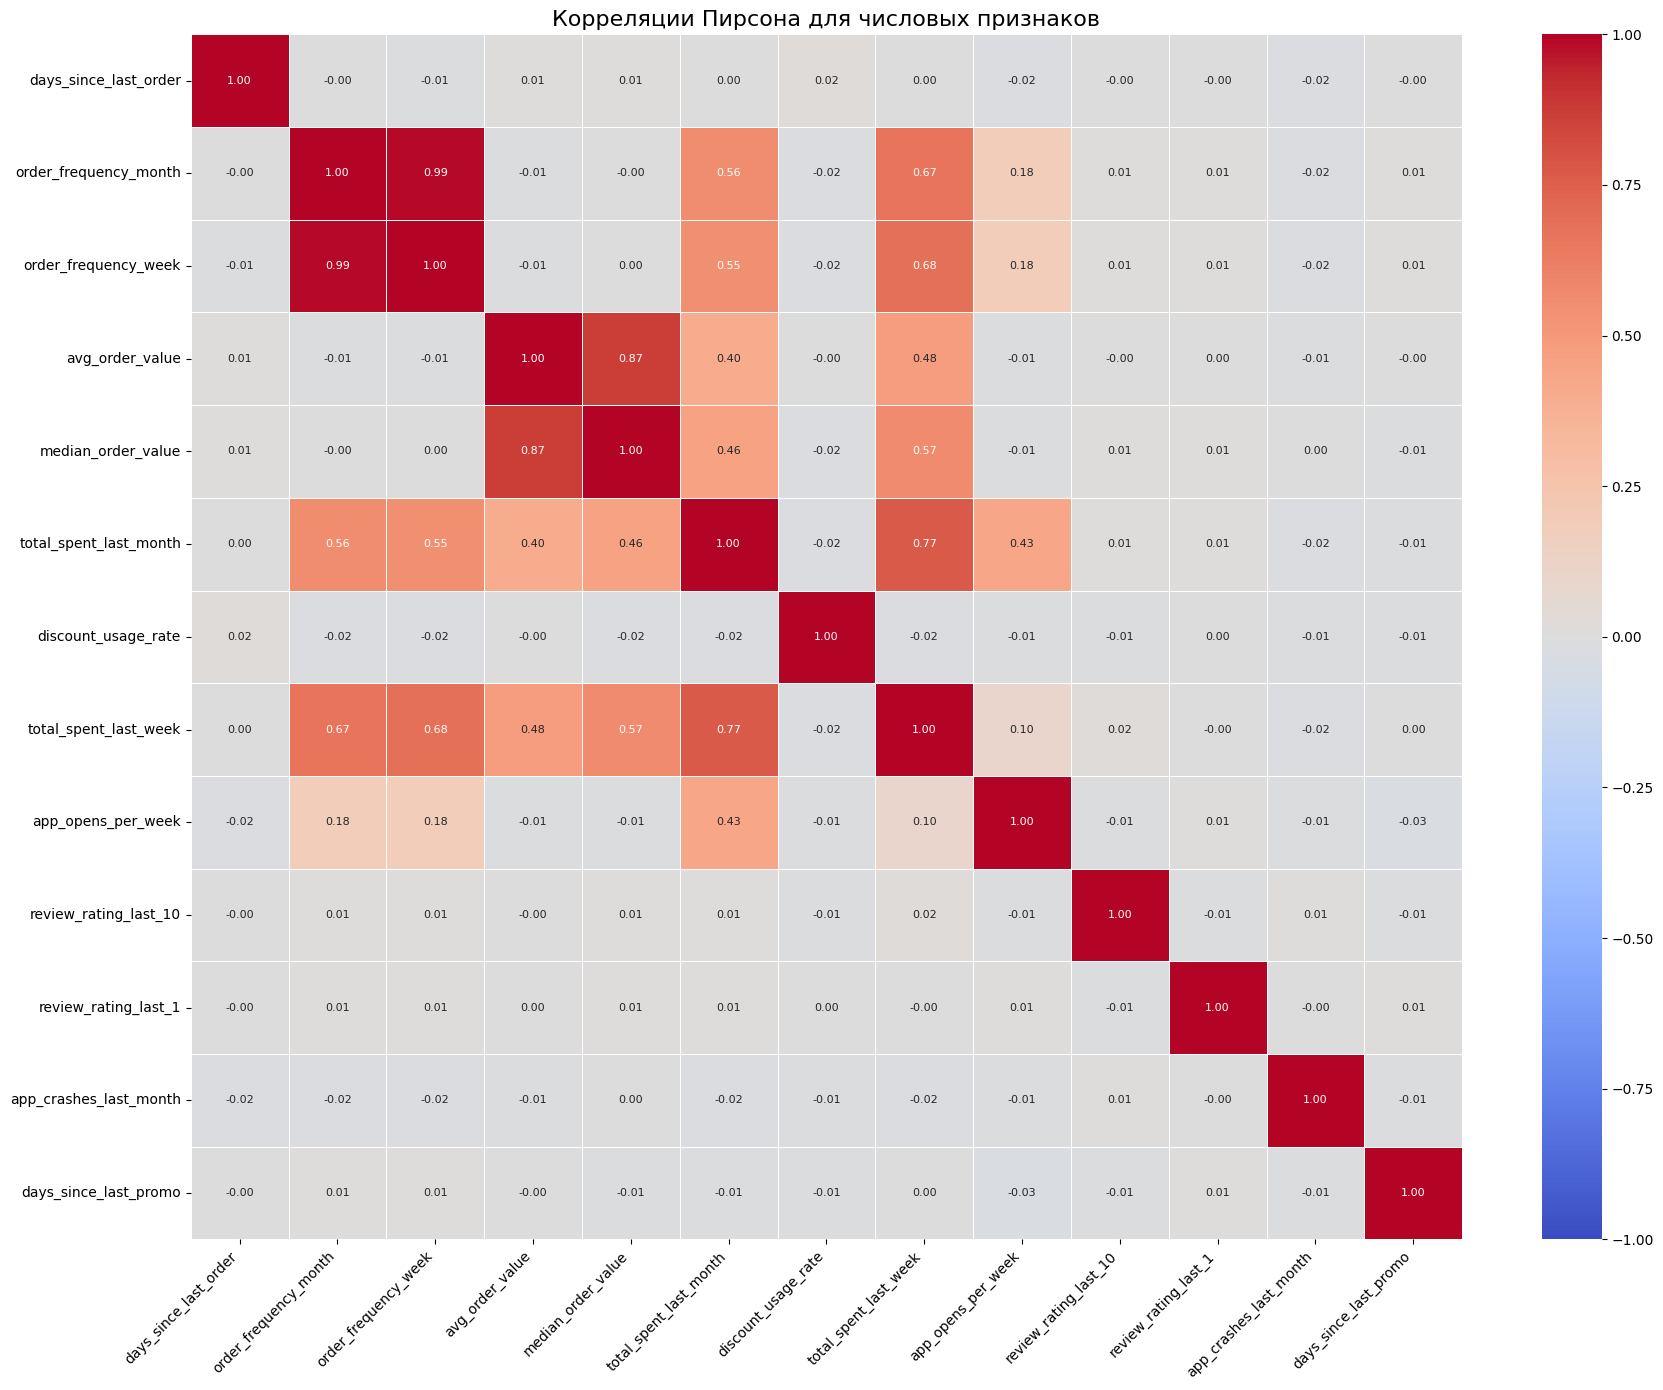

In [19]:
# Для определния корреляции между числовыми признаками используем корреляцию Пирсона

numeric_feature_for_corr = ['days_since_last_order', 'order_frequency_month',
                   'order_frequency_week', 'avg_order_value',
                   'median_order_value', 'total_spent_last_month', 'discount_usage_rate',
                   'total_spent_last_week', 'app_opens_per_week',
                   'review_rating_last_10', 'review_rating_last_1',
                   'app_crashes_last_month','days_since_last_promo'
] # выберем числовые признаки,но исключим бинарные

num_corr = df_orig[numeric_feature_for_corr].corr(method='pearson')

plt.figure(figsize=(18, 14))
sns.heatmap(
    num_corr.round(2),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title('Корреляции Пирсона для числовых признаков', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Выявилась корреляция у признаков:
     -  `order_frequency_month` и `order_frequency_week` - 0,99;
     - `avg_order_value` и `median_order_value` - 0,87;
     - `total_spend_last_month` и `total_spend_last_week` - 0,77;
Данные пары признаков отражают схожие бизнес-процессы или показатели, но за разный промежуток времени. Можно оставить один признак из пары. Мы оставим, как наиболее стабильные: `order_frequency_month`, `median_order_value`, `total_spend_last_month`. Два показателя за более длительный переиод времени, а также медианое значение - стаблиьное к выбросам. 

Переходим к категориальным данным.

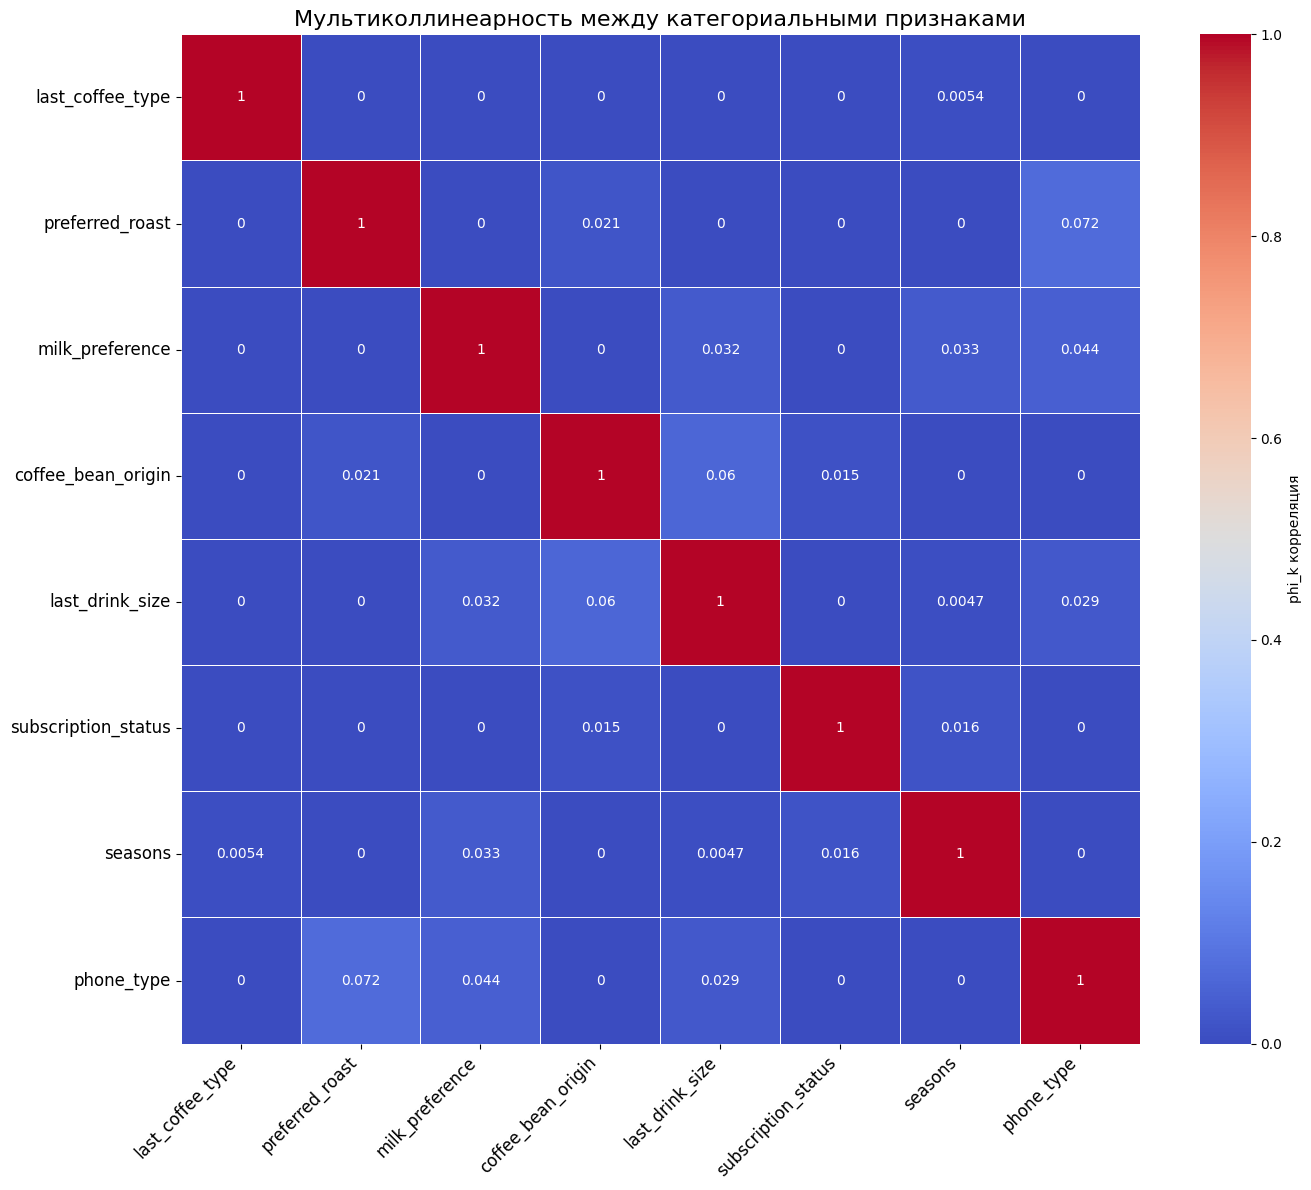

In [20]:
'''---Расчет корреляции между категориальными признаками---'''
categorial_features = ['last_coffee_type', 'preferred_roast',
                       'milk_preference', 'coffee_bean_origin',
                       'last_drink_size', 'subscription_status',
                       'seasons', 'phone_type',
] # возьмем все категориальные признаки, но без геопозиции, ее мы удалили из датасета

cat_df = df_orig[categorial_features].copy()

# расчёт матрицы корреляций phi_k

phi_k_corr = cat_df.phik_matrix()

plt.figure(figsize=(14, 12))
sns.heatmap(
    phi_k_corr,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 10},
    cbar_kws={'label': 'phi_k корреляция'}
)
plt.title('Мультиколлинеарность между категориальными признаками', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

Категориальные признаки не дублируют друг друга, корреляция не наблюдается.

In [21]:
# удаляем поля с корреляцией
col_under_drop = ['order_frequency_week' , 'avg_order_value', 'total_spent_last_week']
df_orig = df_orig.drop(columns=col_under_drop, errors='ignore')
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_order     9505 non-null   float64
 1   order_frequency_month     9850 non-null   float64
 2   median_order_value        9617 non-null   float64
 3   total_spent_last_month    10154 non-null  float64
 4   discount_usage_rate       10053 non-null  float64
 5   last_coffee_type          10192 non-null  object 
 6   preferred_roast           10334 non-null  object 
 7   milk_preference           9782 non-null   object 
 8   seasonal_menu_tried       9461 non-null   float64
 9   coffee_bean_origin        9768 non-null   object 
 10  last_drink_size           9946 non-null   object 
 11  subscription_status       9512 non-null   object 
 12  app_opens_per_week        9554 non-null   float64
 13  notifications_enabled     9913 non-null   float64
 14  review

### Выводы по второму этапу
1. В ходе исследовательского анализа данных был проведён анализ структуры датасета, распределений признаков, пропусков, выбросов и взаимосвязей между признаками.
2. Поведение пользователей отражено в признаках, которые можно разделить на несколько групп:
    - **платежная информация** - цены, чеки, платежи и заказы  
                        (Признаки `order_frequency_month`,
                                  `order_frequency_week`, `avg_order_value`,
                                  `median_order_value`, `total_spent_last_month`,
                                  `total_spent_last_week`, `discount_usage_rate`
                                  ). 
    - **вовлеченность и активность клиента** (Признаки `days_since_last_order`, `app_opens_per_week`,  `notifications_enabled`,
                                                    `days_since_last_promo`, `subscription_status`,
                                                    ).
    - **опыт пользования и оценка клиетов** (Признаки `review_rating_last_10`, `review_rating_last_1`, `app_crashes_last_month`).
    - **вкусовые предпочтения клиентов** (Признаки `last_coffee_type`, `preferred_roast`, `milk_preference`, `seasonal_menu_tried`, `last_drink_size`, `coffee_bean_origin`, `coffee_preference_change`).
    - **фоновый признаки** (Признаки `seasons`, `geo_id`, `phone_type`).
3. Определена целевая переменная `churn`, которая показывает отток клиентов(1- клиент ушел). В целевой переменной обнаружен дисбаланс классов. 6% - положительный класс(отток).
4. Проведено исследование пропусков. Принято решение обработать их в пайплайне на следующем этапе с помощью SimpleImputer.
5. Удалены признаки `user_id` и `geo_location`, т.к признаны не информативными для обучения модели.
6. Произведена оценка выбросов. Принято решение оставить правые хвосты числовых признаков(в большинстве своем), так как эти данные могут быть маркерами либо оттока, либо лояльности клиентов. Обработаны отрицательные значения с помощью замены на NaN. Далее будут заменены на median. 
7. Проведена корреляция по числовым и категориальным признакам(методами Пирсона и Фи коэф соответсвенно). По числовым признаком выявилась корреляция у трех пар признаков, по одному из них были удалены:  `order_frequency_week`, `avg_order_value`, `total_spent_last_week`, как менеее стабильные из пары. По категормальным признакам мультиколлинеарность не обнаружена. Все принято оставить.

## Этап 3. Предобработка данных

1. Разделите данные в пропорции 80 к 20. 20% данных отложите для теста. Остальные используйте для обучения и кросс-валидации модели.

2. Предобработайте данные. Используйте информацию о пропусках и категориальных признаках только из обучающей выборки.

   - Создайте пайплайн, который обработает пропуски и выбросы.

   - Создайте пайплайн, который обработает категориальные признаки.

   - Создайте пайплайн, который обработает числовые признаки: проведёт масштабирование и нормализацию.



In [22]:
'''---Разделие данных---'''
X = df_orig.drop(columns=['churn'])
y = df_orig['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y # стратификация обязательна, когда есть дисбаланс классов
)

In [23]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_order     9505 non-null   float64
 1   order_frequency_month     9850 non-null   float64
 2   median_order_value        9617 non-null   float64
 3   total_spent_last_month    10154 non-null  float64
 4   discount_usage_rate       10053 non-null  float64
 5   last_coffee_type          10192 non-null  object 
 6   preferred_roast           10334 non-null  object 
 7   milk_preference           9782 non-null   object 
 8   seasonal_menu_tried       9461 non-null   float64
 9   coffee_bean_origin        9768 non-null   object 
 10  last_drink_size           9946 non-null   object 
 11  subscription_status       9512 non-null   object 
 12  app_opens_per_week        9554 non-null   float64
 13  notifications_enabled     9913 non-null   float64
 14  review

In [24]:
'''---Ещё раз зафиксируем список числовых и категориальных данных---'''
numeric_features = numeric_feature = [
                    'days_since_last_order', 'order_frequency_month',
                   'median_order_value', 'total_spent_last_month',
                   'discount_usage_rate','seasonal_menu_tried', 
                   'app_opens_per_week',
                   'notifications_enabled', 'review_rating_last_10',
                   'review_rating_last_1', 'app_crashes_last_month',
                   'days_since_last_promo', 'coffee_preference_change'
    
] # числовые признаки
categorial_features = [
    'last_coffee_type',
    'preferred_roast',
    'milk_preference',
    'coffee_bean_origin',
    'last_drink_size',
    'subscription_status',
    'seasons',
    'phone_type'
] # категориальные признаки
total_col = numeric_features + categorial_features
print("Проверяем общее число признаков для контроля:", len(total_col))

Проверяем общее число признаков для контроля: 21


In [25]:
'''---Пайплайны для числовых и категориальных признаков---'''

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()) # заполняем пропуски, проводим масштабирование методом нормализации, как сказано в задании, выбросы не трогаем
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorial_features)
    ]
)


In [26]:
'''---Проверка размерности полученных и предобработанных данных---'''
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)

(8360, 45)
(2090, 45)


In [27]:
# посмотрим что получилось и восстановим имена признаков
feature_names = preprocessor.get_feature_names_out()

X_train_processed_df = pd.DataFrame(
    X_train_processed,
    columns=feature_names,
    index=X_train.index
)
X_train_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8360 entries, 5424 to 1621
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   num__days_since_last_order         8360 non-null   float64
 1   num__order_frequency_month         8360 non-null   float64
 2   num__median_order_value            8360 non-null   float64
 3   num__total_spent_last_month        8360 non-null   float64
 4   num__discount_usage_rate           8360 non-null   float64
 5   num__seasonal_menu_tried           8360 non-null   float64
 6   num__app_opens_per_week            8360 non-null   float64
 7   num__notifications_enabled         8360 non-null   float64
 8   num__review_rating_last_10         8360 non-null   float64
 9   num__review_rating_last_1          8360 non-null   float64
 10  num__app_crashes_last_month        8360 non-null   float64
 11  num__days_since_last_promo         8360 non-null   float64

В целом все выглядит корректно

## Этап 4. Обучение модели

1. Обучите базовую версию модели.
   - Используйте для этого простые статистические модели.

   - Используйте кросс-валидацию для обучения модели.

2. Посчитайте метрики, поставленные в задаче. Опираясь на них, сделайте вывод о качестве модели.

In [28]:
"""---Базовая модель---"""
dummy = DummyClassifier(strategy='most_frequent', random_state=SEED)

dummy_cv = cross_validate(
    dummy,
    X_train,
    y_train,
    cv=5,
    scoring={
        'pr_auc': 'average_precision',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
    }
)

pd.DataFrame(dummy_cv).mean()

c:\Users\User\Desktop\ЯПрактикум\Проект №6\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\ЯПрактикум\Проект №6\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\ЯПрактикум\Проект №6\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

fit_time          0.001784
score_time        0.009479
test_pr_auc       0.060167
test_precision    0.000000
test_recall       0.000000
test_f1           0.000000
dtype: float64

Dummy модель показывает следующие метрики: test_pr_auc =0.060167. Это логично, ведь наш положительный класс находится на уровне 6%. Она показывает частоту положительного класса. Остальные метрики равны 0, модель предсказывает превалирующий класс(это те кто остается). И не находит тех, кто ушел. Это происходит из-за дизбаланса классов.

In [29]:
'''---Простая модель с логистической регрессией---'''
logreg = LogisticRegression(
    solver='liblinear',
    class_weight='balanced', # применяется при несбалансированных классах
    random_state=SEED,
    max_iter=1000
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

In [30]:
'''---Кросс-валидация для логистической модели---'''
logreg_cv = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring={
        'pr_auc': 'average_precision',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
    },
)

pd.DataFrame(logreg_cv).mean()

fit_time          0.055381
score_time        0.019077
test_pr_auc       0.627341
test_precision    0.287687
test_recall       0.850851
test_f1           0.429981
dtype: float64

In [31]:
# Сохраним результаты в единый DataFrame
def log_model_results(results_df, model_name, cv_results):
    
    results_df.loc[len(results_df)] = {
        'model': model_name,
        'pr_auc': cv_results['test_pr_auc'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    }
    
    return results_df

results = pd.DataFrame(columns=['model', 'pr_auc', 'precision', 'recall', 'f1'])

results = log_model_results(results, 'DummyClassifier', dummy_cv)
results = log_model_results(results, 'LogReg_baseline', logreg_cv)

results.set_index('model').round(3)


,pr_auc,precision,recall,f1
model,,,,
DummyClassifier,0.060,0.000,0.000,0.00
LogReg_baseline,0.627,0.288,0.851,0.43


**Сравним получившиеся результаты**
1. pr_auc 
    - В Dummy 0,06(модель соответствует чистослучайному угадыванию, результат не превышает реальный процент уходящих клиентов);
    - в logreg 0,63(модель извлекает полезную информацию из признаков почти в 10 раз лучше, чем случайная модель);
2. precision(насколько точно модель отлавливает действительно ушедших клиентов)
    - В Dummy 0 - вообще не определяет
    - в logreg 0,29. Около 29 % клиентов, которых модель считает ушедшими - действитлено такими являются. 
3. recall (доля реально ушедших клиентов из всех ушедших)
    - В Dummy 0 - вообще не смогла обнаружить уходящих клиентов
    - logreg 0,85 - модель находит 85% всех клиентов, которые уходят(т.е модель почти не пропускает склонных оттоков клиентов, хотя иногда и путает их с несклонными, судя по precision)
4. f1 (балансны показатель между precision и recall)
    - В Dummy 0 - аналогично предыдущим метрикам(считается из них)
    - logreg 0,43 - баланс между ложными тревогами и отлавливливанием уходящих клиентов.
5. *Логистическая регрессия значительно превосходит базовую модель по всем ключевым метрикам и может использоваться как основа для дальнейшего улучшения*

## Этап 5. Создание новых признаков

1. Добавьте новые признаки, которые могут улучшить качество модели. Опирайтесь на наработки, полученные в ходе исследовательского анализа данных, и на логику решаемой задачи.

   - Извлечение квадратного корня поможет сгладить большие значения.

   - Возведение в квадрат усилит влияние больших значений.

2. Обновите пайплайн для работы с новыми признаками, проведите повторную кросс-валидацию, сравните результаты моделей с новыми признаками и без них.

3. Интерпретируйте коэффициенты модели, а затем на их основании выявите значимые признаки и удалите лишние для модели.

В качестве создания новых признаков сделаем следующие:
 - `sqrt_total_spent_last_month` (корень из затрат за месяц), так как это большие числа, корень несколько сгладит, в том числе и выбросы.
 - `sq_days_since_last_order` квадрат дней последнего заказа. Чем больше дней проходит с моента последнего заказа, тем выше вероятность, что клиент ушел. Квадрат будет усиливать сигнал.
 - `is_premium_plan` - бинарный признак, есть ли премиум план - может быть маркером лояльности клиента.

In [32]:
"""---Создаем новые признаки---"""

def generate_features(X):
    # делаем в виде функции, чтобы поптом вставить в пайплайн
    X = X.copy()
    # sqrt — вместо total_spent_last_month
    X['sqrt_total_spent_last_month'] = np.sqrt(X['total_spent_last_month'].clip(lower=0))
    # square — вместо days_since_last_order
    X['days_since_last_order_sq'] = X['days_since_last_order'] ** 2
    # premium flag
    X['is_premium_plan'] = (X['subscription_status'] == 'premium').astype(int)

    # удаляем исходные признаки
    X = X.drop(columns=[
        'total_spent_last_month',
        'days_since_last_order'
    ])

    return X


In [33]:
# Выделим новые числовые признаки
numeric_features_ext = [
    'order_frequency_month',
    'median_order_value',
    'discount_usage_rate',
    'seasonal_menu_tried',
    'app_opens_per_week',
    'notifications_enabled',
    'review_rating_last_10',
    'review_rating_last_1',
    'app_crashes_last_month',
    'days_since_last_promo',
    'coffee_preference_change',
    'sqrt_total_spent_last_month',
    'days_since_last_order_sq',
    'is_premium_plan'
]
# категориальные не изменились
categorial_features = [
    'last_coffee_type',
    'preferred_roast',
    'milk_preference',
    'coffee_bean_origin',
    'last_drink_size',
    'subscription_status',
    'seasons',
    'phone_type'
]

In [34]:
"""---Обновляем пайплайны---"""
numeric_pipeline_ext = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ]
)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_ext = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_ext, numeric_features_ext),
        ('cat', categorical_pipeline, categorial_features)
    ]
)

In [35]:
"""---Модель с новыми признаками и кросс-валидация---"""

model_ext = Pipeline(
    steps=[
        ('feature_gen', FunctionTransformer(generate_features)),
        ('preprocessor', preprocessor_ext),
        ('classifier', LogisticRegression(
            solver='liblinear',
            class_weight='balanced',
            random_state=SEED,
            max_iter=1000
        ))
    ]
)

In [36]:
"""---Кросс-валидация---"""
logreg_ext_cv = cross_validate(
    model_ext,
    X_train,
    y_train,
    cv=5,
    scoring={
        'pr_auc': 'average_precision',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }
)

results = log_model_results(results, 'LogReg_feat_eng', logreg_ext_cv)
print(results.set_index('model'))


                   pr_auc  precision    recall        f1
model                                                   
DummyClassifier  0.060167   0.000000  0.000000  0.000000
LogReg_baseline  0.627341   0.287687  0.850851  0.429981
LogReg_feat_eng  0.627512   0.287650  0.850832  0.429937


Новые признаки не пивнесли больших измеений в метики. pr_auc чуть подрос, но на уровне шума. По остальным метрикам аналогчно. Но они чуть упали. Значит исходные данные уже хорошо описывают поведение клиента. Или моя генерация пизнаков оказалась не удачной.

In [37]:
"""---Получение и интерпретация весов модели---"""
# для удобства интерпретации получим имена после енкодера
model_ext.fit(X_train, y_train)
feature_names = model_ext.named_steps['preprocessor'].get_feature_names_out()

In [38]:
coefs = model_ext.named_steps['classifier'].coef_[0]
coef_df = (
    pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs
    })
)

print(coef_df.head(50))

                              feature  coefficient
0          num__order_frequency_month     4.605978
1             num__median_order_value     0.099241
2            num__discount_usage_rate     0.016114
3            num__seasonal_menu_tried    -0.451138
4             num__app_opens_per_week     2.555864
5          num__notifications_enabled    -0.223810
6          num__review_rating_last_10    -0.553719
7           num__review_rating_last_1     0.476262
8         num__app_crashes_last_month    10.886158
9          num__days_since_last_promo     0.975780
10      num__coffee_preference_change    -0.017687
11   num__sqrt_total_spent_last_month    -0.096939
12      num__days_since_last_order_sq    -0.198677
13               num__is_premium_plan    -0.135244
14      cat__last_coffee_type_arabica    -0.541999
15        cat__last_coffee_type_blend    -0.473616
16      cat__last_coffee_type_robusta    -0.140007
17          cat__preferred_roast_dark    -0.290049
18         cat__preferred_roast

По коэффициентам признаков можно сказать следующее:
 - **топ положительно влияющих на отток клиентов**
    1. `app_crashes_last_month` +10,89. Это самый большое вес. Нестабильность приложения сильно раздражает клиентов вплодь до ухода. Рекомендация бизнесу: "наладить работу приложения"
    2. `order_frequency_month` +4.61 неочивидный признак, чем чаще заказы, тем сильнее отток клиентов. Скорее всего меню однообразное и клиенты пресыщаются быстро. Значит нужно разнообразить меню. Или это последний всплеск активности перед уходом.
    3. `subscription_status_pro` +0.63 третье по влиянию на отток клиентов. Возможно слишком дорогая подписка, что не соответтсвует качетсву работы приложения и ожиданиям клиентов.
    4. `num_days_since_last_promo` +0,99 Чем больше количество дней прошло с акции, тем больше отток. Нужно делать больше акций, они действительно удачные.
- **топ положительно влияющих на удержание клиентов**
    1. `subscription_status_premium` -0,14 - премиум подписка способна уменьшить отток клиентов. Должно быть там есть хорошие предложения для удержания. Для бизнеса можно запустить акцию - новым клиентам месяц подписки бесплатно. Или похожие условия бесплатной подписки для текущих клиентов.
    2. `seasonal_menu_tried` -0.45 - те, кто пробовал сезонное меню остаются чаще;
    3. `preferred_roast_light` -0,51 - люди предпочитающий светлый сорт более лояльны.
    4. `phone_type_web` -0,62. Веб версия снижает отток. Должно быть проблемы с приложением только на мобильных платформах.

*Итого - самая большая проблема, это плохая работа мобильного приложения*

К удалению рекомендованы следующие признаки с наименьшими коэффициентами:
    - *из числовых*</br>
    - discount_usage_rate 0.016</br>
    - coffee_preference_change 0.018</br>
    - sqrt_total_spent_last_month 0.097</br>
    - *из категориальных*</br>
    - milk_preference_oat 0.017</br> - но этот признак удалить не получится так как он результат кодирования. А остальные признаки по предпочтениям молока все таки имеют вес.
    - coffee_bean_origin_ethiopia 0.045</br>


In [39]:
# убираем лишние числовые и категориальные признаки
numeric_features_reduced = [ # создаем новый уменьшенный набор признаков
    f for f in numeric_features
    if f not in [
        'discount_usage_rate',
        'coffee_preference_change',
        'sqrt_total_spent_last_month'
    ]
]

categorical_features_reduced = [
    f for f in categorial_features
    if f not in [
        'coffee_bean_origin_ethiopia']
]

# обновляем препроцессор для следующей работы с гиперпараметрами
preprocessor_ext = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features_reduced),
        ('cat', categorical_pipeline, categorical_features_reduced)
    ]
)

## Этап 6. Эксперименты с гиперпараметрами

1. Перечислите все гиперпараметры, с которыми планируете экспериментировать.

2. Проведите систематический перебор гиперпараметров для `LogisticRegression`, выполните кросс-валидацию для каждой конфигурации.

3. Составьте таблицу с результатами.

4. Выберите лучшую модель, ориентируясь на заданную метрику качества.

Из гиперпараметров для логистической регресси предлагаю поэкспериментировать со следующими:
- С - сила регуляризации
- class_weight - способ учета дисбаланса, его уже использовали выше.

In [40]:
# Для перебора гиперпараметров, напишем функцию, которая выполняет процесс предобработки 
# и получения результатов модели лог регрессии с кросс-валидацией.

def evaluate_logreg_simple(
    preprocessor,
    X,
    y,
    C,
    class_weight,
    model_name
):
    model = LogisticRegression(
        C=C,
        solver='liblinear',
        class_weight=class_weight,
        random_state=42,
        max_iter=1000
    )

    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ]
    )

    scores = cross_validate(
        pipeline,
        X,
        y,
        scoring={
            'pr_auc': 'average_precision',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1'
        },
        cv=5
    )

    return {
        'model': model_name,
        'C': C,
        'class_weight': class_weight,
        'pr_auc': scores['test_pr_auc'].mean().round(3),
        'precision': scores['test_precision'].mean().round(3),
        'recall': scores['test_recall'].mean().round(3),
        'f1': scores['test_f1'].mean().round(3)
    }



In [41]:
# цикл для перебор параметров
results = []

C_values = [0.1, 1, 10]
class_weights = [
    None,
    'balanced',
    {0: 1, 1: 10},
    {0: 1, 1: 15}
]

for C in C_values:
    for cw in class_weights:
        results.append(
            evaluate_logreg_simple(
                preprocessor=preprocessor_ext,
                X=X_train,
                y=y_train,
                C=C,
                class_weight=cw,
                model_name='LogReg_tuned'
            )
        )

results_df = (
    pd.DataFrame(results)
    .sort_values('pr_auc', ascending=False)
)

print(results_df)


           model     C   class_weight  pr_auc  precision  recall     f1
8   LogReg_tuned  10.0           None   0.665      0.770   0.432  0.551
4   LogReg_tuned   1.0           None   0.661      0.845   0.354  0.495
6   LogReg_tuned   1.0  {0: 1, 1: 10}   0.639      0.359   0.813  0.498
10  LogReg_tuned  10.0  {0: 1, 1: 10}   0.639      0.358   0.815  0.497
2   LogReg_tuned   0.1  {0: 1, 1: 10}   0.634      0.377   0.801  0.513
7   LogReg_tuned   1.0  {0: 1, 1: 15}   0.630      0.293   0.845  0.436
3   LogReg_tuned   0.1  {0: 1, 1: 15}   0.630      0.292   0.845  0.434
5   LogReg_tuned   1.0       balanced   0.630      0.288   0.851  0.431
11  LogReg_tuned  10.0  {0: 1, 1: 15}   0.629      0.293   0.845  0.435
9   LogReg_tuned  10.0       balanced   0.628      0.288   0.849  0.430
1   LogReg_tuned   0.1       balanced   0.622      0.284   0.847  0.426
0   LogReg_tuned   0.1           None   0.620      1.000   0.066  0.123


Исходя из требований задания, главная метрика - это pr_auc. Это модель, где С=10, class_weight=None. У данной модели pr_auc=0.665(это лучший результат), percision=0.77(точность достаточно высокая 77% верных попаданий - программа удержания будет расходовать бюджет практически полностью по целевому назначению), recall=0.432(находит 43% уходящих из всех), а f1=0,551(также лучший результат - оптимальный баланс между recall и precision)

## Этап 7. Подготовка финальной модели

Объедините лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучите модель на всех данных для кросс-валидации и проведите финальную оценку на отложенной тестовой выборке.


In [42]:
# Финальный препроцессор с уменьшенным набором признаков
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_ext, numeric_features_reduced),   # или numeric_pipeline, если ты его не менял
        ('cat', categorical_pipeline, categorical_features_reduced)
    ],
    remainder='drop'
)

final_model = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('classifier', LogisticRegression(
        C=10.0,
        class_weight=None,
        solver='liblinear',
        random_state=42,
        max_iter=1000
    ))
])

In [43]:
# обучаем модель на тренировочных данных
final_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [44]:
# проводим финальную оценку на тестовой выборке
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

final_metrics = {
    'PR-AUC (average_precision)': average_precision_score(y_test, y_pred_proba),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1-score': f1_score(y_test, y_pred, zero_division=0)
}

print(pd.DataFrame([final_metrics]).round(3))

   PR-AUC (average_precision)  Precision  Recall  F1-score
0                       0.705      0.846   0.437     0.576


In [ ]:
# проводим финальную оценку на тестовой выборке
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

final_metrics = {
    'PR-AUC (average_precision)': average_precision_score(y_test, y_pred_proba),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1-score': f1_score(y_test, y_pred, zero_division=0)
}

print(pd.DataFrame([final_metrics]).round(3))

   PR-AUC (average_precision)  Precision  Recall  F1-score
0                       0.705      0.846   0.437     0.576


## Этап 8. Отчёт о проделанной работе

Проанализируйте итоговые метрики модели и факторы, которые на них повлияли. Составьте описание, выделив наиболее важные факторы.

Финальная модель на тестовой выборке показала результаты:
- PR-AUC=0.705; - Хороший результат. Превосходит модель на тренировочных данных. Модель показывает высокую способность определять редкий положительный класс оттока клиентов.
- Precision=0.846 Высокая точность. модель верно определяет 85% положительного класса;
- Recall=0.437 практически не изменилась на тестовых данных. Метрика стабильна;
- F1=0.576 Данная метрика выросла за счет percision Все еще оптимальный баланс между Precision и Recall.

Повлиявшие факторы: 
1. Удаление шумящих признаков. Сокращение размерности данных минимизировало переобучение, что отразилось в высокой Precision (0.846), снижая ложные положительные предсказания. Это также стабилизировало F1-score на уровне 0.576.
2. Настройка гиперпараметров и кросс-валидация. Выбор регуляризации и отказ от class_weight='balanced' (в пользу None) обеспечил лучший баланс между Precision и Recall, фокусируясь на PR-AUC как основной метрике для дисбаланса.
3. Обработка данных в пайплайне (импутация, масштабирование, OHE): Стандартизация через MinMaxScaler и SimpleImputer повысила обобщаемость, способствуя росту всех метрик на тесте по сравнению с кросс-валидацией.

## Этап 9. Сохранение модели для продакшена

Сохраните итоговую модель и пайплайн предобработки. Убедитесь, что всё работает: загрузите артефакты и проверьте их на тестовых данных. В решении укажите ссылку для скачивания сохранённых файлов.

In [45]:
# сохраняем итоговую модель
joblib.dump(final_model, 'final_pipeline_model.joblib')

print("Модель сохранена в файл: final_pipeline_model.joblib")

Модель сохранена в файл: final_pipeline_model.joblib


Проверим сохраненную модель

In [46]:
# Делаем предсказания на тестовых данных
loaded_model = joblib.load('final_pipeline_model.joblib')
y_pred_loaded     = loaded_model.predict(X_test)
y_pred_proba_loaded = loaded_model.predict_proba(X_test)[:, 1]

# Считаем метрики
metrics_loaded = {
    'PR-AUC':     average_precision_score(y_test, y_pred_proba_loaded),
    'Precision':  precision_score(y_test, y_pred_loaded, zero_division=0),
    'Recall':     recall_score(y_test, y_pred_loaded, zero_division=0),
    'F1':         f1_score(y_test, y_pred_loaded, zero_division=0)
}

# Сравниваем с оригинальными значениями
print("\nМетрики после загрузки модели:")
print(pd.Series(metrics_loaded).round(4))


Метрики после загрузки модели:
PR-AUC       0.7045
Precision    0.8462
Recall       0.4365
F1           0.5759
dtype: float64


Артефакт модели сохранён в файл final_pipeline_model.joblib.
После загрузки с помощью joblib.load модель успешно применилась к тестовым данным.
Полученные метрики полностью совпадают с оригинальными (PR-AUC 0.705, Precision 0.846, Recall 0.437, F1 0.576), что подтверждает корректность сохранения и воспроизводимость пайплайна.